## Pipeline for analysis

    A notebook that shows how to manipulate/visualize large datasets from model results

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#import all the things

%reset
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import cmocean as cm
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools)
import xarray as xr 
import subprocess 
import cmocean

%matplotlib inline

# Find yr data and open and print it with xarray

In [3]:
resdir = '/data/tjarniko/results/mar7_sept2016_3B/'
indexer = 480
# PHYS = 'SalishSea_1h_20160901_20160911_grid_T.nc'
# SMELT = 'SalishSea_1h_20160901_20160911_ptrc_T.nc'
bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
# smelt_res = xr.open_dataset(resdir + SMELT)
# phys_res = xr.open_dataset(resdir+PHYS)


# Subset individual variables with ncks for speed

In [4]:
%time subprocess.call('ncks -v dissolved_inorganic_carbon SalishSea_1h_20160921_20160930_ptrc_T.nc DIC_1h.nc', shell=True,cwd=resdir)
%time subprocess.call('ncks -v total_alkalinity SalishSea_1h_20160921_20160930_ptrc_T.nc TA_1h.nc', shell=True,cwd=resdir)
%time subprocess.call('ncks -v vosaline SalishSea_1h_20160921_20160930_grid_T.nc sn_1h.nc', shell=True,cwd=resdir)


CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 4min 50s
CPU times: user 8 ms, sys: 12 ms, total: 20 ms
Wall time: 4min 45s
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 4min 41s


0

In [5]:
DIC = nc.Dataset(resdir + 'DIC_1h.nc')
TA = nc.Dataset(resdir + 'TA_1h.nc')
sal = nc.Dataset(resdir + 'sn_1h.nc')

DIC_dat = DIC.variables['dissolved_inorganic_carbon']
TA_dat = TA.variables['total_alkalinity']
sal_dat = sal.variables['vosaline']
#print(DIC_dat[2,2,:,:])

# DIC_var = DIC.variables['dissolved inorganic carbon']
# TA_var =  TA.variables('total alkalinity')
# sal_var = sn.variables('vosaline')

print(sal_dat.shape)

(240, 40, 898, 398)


# Plots and animations! - ONC deep station

In [6]:
def nice_CN_plot(tit1, tit2, plotdat,t, v_min, v_max, tcmap, clabel):
    fig, (axl, axr) = plt.subplots(1, 2, figsize=(16, 8 ))
    land_colour = 'whitesmoke'
    
    daypath = '/results/SalishSea/hindcast/01sep17/SalishSea_1d_20170901_20170901_grid_T.nc' 
    t_d = nc.Dataset(daypath)

    zlevels = t_d.variables['deptht']

    # Define the component slice to plot
    zmax, ylocn = 41, 424
    section_slice = np.arange(208, 293)

    pdat = np.ma.masked_values(plotdat[t,:,424,section_slice],0)
    
    cmap = tcmap
    #cmap.set_bad(land_colour)
    #cmap.set_bad('whitesmoke')
    mesh = axl.pcolormesh(
        section_slice[:], zlevels[:zmax], pdat,
        cmap=cmap, vmin=v_min, vmax=v_max,
    )
    axl.invert_yaxis()
    cbar = fig.colorbar(mesh, ax=axl)
    cbar.set_label(clabel)

    # Axes labels and title
    axl.set_xlabel('x Index')
    axl.set_ylabel('depth (m)')
    axl.set_title(tit1)

    # Axes limits and grid
    axl.set_xlim(section_slice[1], section_slice[-1])
    axl.set_ylim(zlevels[zmax - 2] + 10, 0)
    axl.set_facecolor(land_colour)
    axl.grid()

    # Define surface current magnitude slice
    x_slice = np.arange(0, 398)
    y_slice = np.arange(0, 898)
    line_s = np.arange(0,398)

    
    surf_dat =  np.ma.masked_values(plotdat[t, 0, y_slice, x_slice], 0)
    
    viz_tools.set_aspect(axr)
    axr.plot(
        line_s, 424*np.ones_like(line_s),
        linestyle='solid', linewidth=3, color='black',
        label='Section Line',
    )
    
    cmap.set_bad(land_colour)
    

    #cmap.set_bad('whitesmoke')
    mesh = axr.pcolormesh(surf_dat, cmap=tcmap, vmin = v_min, vmax = v_max)

    # Axes labels and title
    axr.set_xlabel('')
    axr.set_ylabel('')
    axr.set_xticks([])
    axr.set_yticks([])
    axr.set_title(tit2)
    legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
    axr.grid()

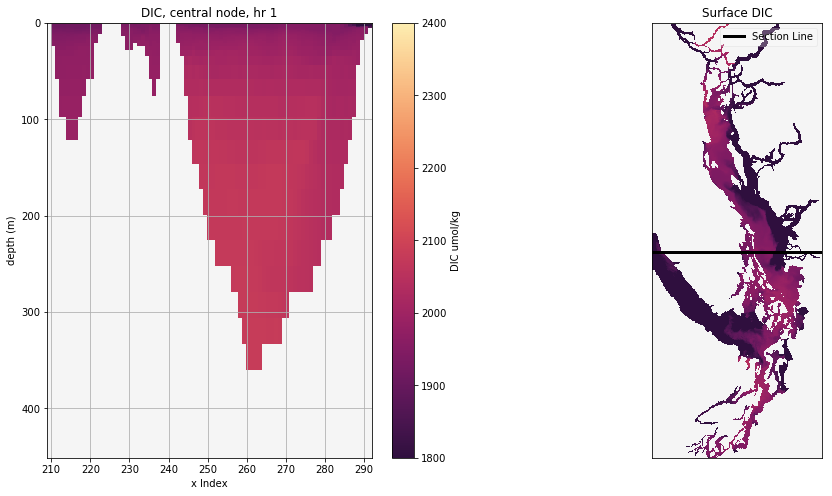

In [7]:
nice_CN_plot('DIC, central node, hr 1', 'Surface DIC', DIC_dat,0, 1800, 2400, cm.cm.matter_r, 'DIC umol/kg')

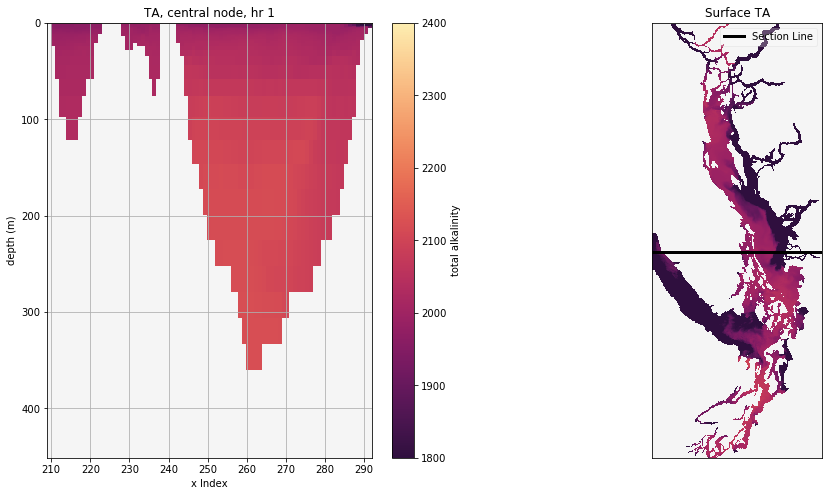

In [8]:
nice_CN_plot('TA, central node, hr 1', 'Surface TA', TA_dat,0, 1800, 2400, cm.cm.matter_r, 'total alkalinity')

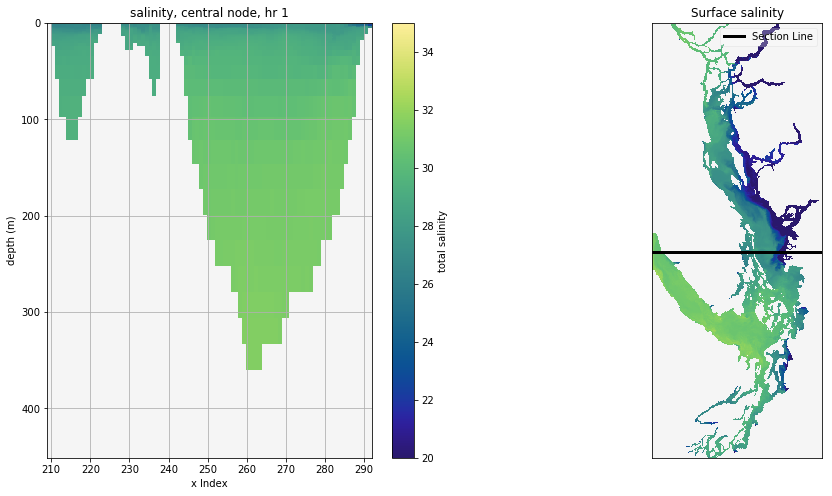

In [9]:
nice_CN_plot('salinity, central node, hr 1', 'Surface salinity', sal_dat,0, 20, 35, cm.cm.haline, 'total salinity')

# Plots and animations! - Thalweg

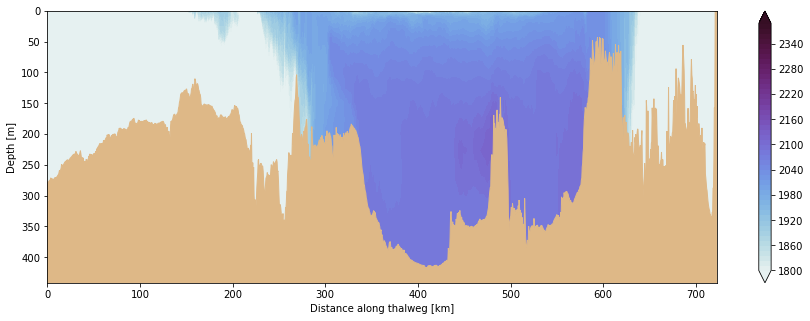

In [10]:
i = 0
td = DIC_dat[i,:,:,:]
cmap = cm.cm.dense
vmin = 1800
vmax = 2400
stepsize = 12
fig,ax = plt.subplots(1,1,figsize=(15,5))
vis.contour_thalweg(ax, td, bathy, mesh, np.arange(vmin, vmax, stepsize), cmap = cmap)

In [11]:
def thalweg_animator(plotdat,tstart,tend,vmin,vmax,stepsize,tit,figtit,dirstr,indexer):
    for i in range(tstart,tend):
        td = plotdat[i,:,:,:]
        cmap = cm.cm.dense
        fig,ax = plt.subplots(1,1,figsize=(15,5))

        cbar = vis.contour_thalweg(ax, td, bathy, mesh, np.arange(vmin, vmax, stepsize), cmap = cmap)
        
        t_i = indexer + i
        si = str(t_i)
        #print(len(si))
        if len(si) == 1:
            lsi = '00' + si
        if len(si) == 2:
            lsi = '0' + si
        if len(si) == 3:
            lsi = si
        print(lsi)
        fig.suptitle(tit + str(lsi))
        fig.savefig(dirstr+figtit+str(lsi))
        plt.close(fig)

## Reimport animations and plots

In [12]:
plotdat = DIC_dat
print(plotdat.shape)

cmap = cm.cm.dense
vmin = 1800
vmax = 2400
stepsize = 12
tit = 'DIC along thalweg, hour '
figtit = 'DICSept1_hr'
dirstr = './DIC/'
# numfram = 240
# indexer = 480

thalweg_animator(plotdat,0,240,vmin,vmax,stepsize,tit,figtit,dirstr,indexer)


(240, 40, 898, 398)
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719


In [13]:
def ONC_animator(plotdat,tstart,tend,v_min,v_max,stepsize,tit1,tit2,figtit,dirstr,tcmap,clabel,indexer):
    for i in range(tstart,tend):
        fig, (axl, axr) = plt.subplots(1, 2, figsize=(16, 8 ))
        land_colour = 'whitesmoke'

        daypath = '/results/SalishSea/hindcast/01sep17/SalishSea_1d_20170901_20170901_grid_T.nc' 
        t_d = nc.Dataset(daypath)

        zlevels = t_d.variables['deptht']

        # Define the component slice to plot
        zmax, ylocn = 41, 424
        section_slice = np.arange(208, 293)

        pdat = np.ma.masked_values(plotdat[i,:,424,section_slice],0)

        cmap = tcmap
        mesh = axl.pcolormesh(
            section_slice[:], zlevels[:zmax], pdat,
            cmap=cmap, vmin=v_min, vmax=v_max,
        )
        axl.invert_yaxis()
        cbar = fig.colorbar(mesh, ax=axl)
        cbar.set_label(clabel)

        # Axes labels and title
        axl.set_xlabel('x Index')
        axl.set_ylabel('depth (m)')
        axl.set_title(tit1)

        # Axes limits and grid
        axl.set_xlim(section_slice[1], section_slice[-1])
        axl.set_ylim(zlevels[zmax - 2] + 10, 0)
        axl.set_facecolor(land_colour)
        axl.grid()

        # Define surface current magnitude slice
        x_slice = np.arange(0, 398)
        y_slice = np.arange(0, 898)
        line_s = np.arange(0,398)
        
        surf_dat =  np.ma.masked_values(plotdat[i, 0, y_slice, x_slice], 0)
        viz_tools.set_aspect(axr)
        axr.plot(
            line_s, 424*np.ones_like(line_s),
            linestyle='solid', linewidth=3, color='black',
            label='Section Line',
        )

        cmap.set_bad(land_colour)
        mesh = axr.pcolormesh(surf_dat, cmap=tcmap, vmin = v_min, vmax = v_max)

        # Axes labels and title
        axr.set_xlabel('')
        axr.set_ylabel('')
        axr.set_xticks([])
        axr.set_yticks([])
        axr.set_title(tit2)
        legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
        axr.grid()
        
        t_i = indexer + i
        si = str(t_i)
        #print(len(si))
        if len(si) == 1:
            lsi = '00' + si
        if len(si) == 2:
            lsi = '0' + si
        if len(si) == 3:
            lsi = si
        print(lsi)
        fig.suptitle(tit + str(i))
        fig.savefig(dirstr+figtit+str(lsi))
        plt.close(fig)


In [14]:
ONC_animator(DIC_dat,0,240,1800,2400,12,'DIC central node, hr ','Surface_DIC_test','Surface_DIC_test','./DIC_ONC/',cm.cm.dense,'DIC umol/kg',480)

480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
